In [10]:
import sys
sys.path.append('..')
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import pandana as pdn
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import warnings
import os
import json
from shapely.geometry import Point

warnings.filterwarnings("ignore")

In [11]:
from glob import glob
glob('/app/assets/streets/*/nodes')

['/app/assets/streets/actual/nodes', '/app/assets/streets/future/nodes']

In [12]:
def get_nodes_and_edges_in_plate(nodes, edges, plate):
    select_nodes = gpd.sjoin(nodes, plate, how='inner')
    select_edges = edges[edges['u'].isin(select_nodes.osmid) | edges['v'].isin(select_nodes.osmid)]
    select_nodes = nodes[nodes['osmid'].isin(select_edges['u']) | nodes['osmid'].isin(select_edges['v'])]
    return select_nodes, select_edges

In [13]:
default_crs = '32718'

In [14]:
actual_nodes = gpd.read_file('/app/assets/streets/actual/nodes').to_crs(default_crs)
actual_edges = gpd.read_file('/app/assets/streets/actual/edges').to_crs(default_crs)

In [15]:
future_nodes = gpd.read_file('/app/assets/streets/future/nodes').to_crs(default_crs)
future_edges = gpd.read_file('/app/assets/streets/future/edges').to_crs(default_crs)

In [16]:
area_scope = gpd.read_file('/app/assets/area_scope').to_crs(default_crs)

In [22]:
actual_edges['plate_id'] = 0
actual_nodes['plate_id'] = 0
future_edges['plate_id'] = 0
future_nodes['plate_id'] = 0

In [47]:
nodes = actual_nodes.copy()
edges = actual_edges.copy()

plate_id = 1
plate = gpd.read_file(f'/app/assets/plates/{plate_id}').to_crs(default_crs)

select_nodes = gpd.sjoin(nodes, plate, how='inner')
edges_mask = edges['u'].isin(select_nodes.osmid) | edges['v'].isin(select_nodes.osmid)
select_edges = edges[edges_mask]
nodes_mask = nodes['osmid'].isin(select_edges['u']) | nodes['osmid'].isin(select_edges['v'])
select_nodes = nodes[nodes_mask]

nodes.loc[nodes_mask, 'plate_id'] = plate_id
edges.loc[edges_mask, 'plate_id'] = plate_id

# mask_future_edges = ~select_future_edges['osmid'].isin(select_actual_edges['osmid'])
# edges_to_change = gpd.sjoin(select_future_edges[mask_future_edges], plate, how='inner')

In [59]:
nodes.to_parquet('/app/data/output/nodes.parquet')
edges.to_parquet('/app/data/output/edges.parquet')

In [60]:
nodes = gpd.read_parquet('/app/data/output/nodes.parquet')

In [61]:
edges = gpd.read_parquet('/app/data/output/edges.parquet')

In [54]:
nodes = gpd.read_file('/app/assets/streets/actual/nodes')

<Axes: >

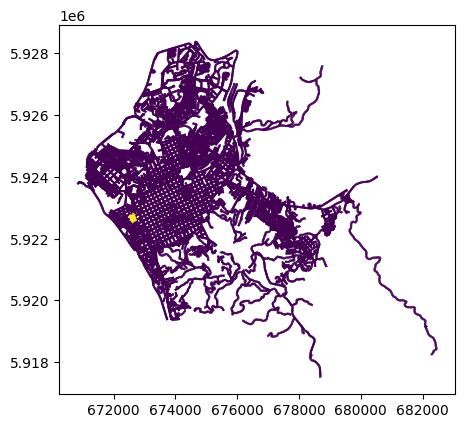

In [49]:
edges.plot(column='plate_id')

<Axes: >

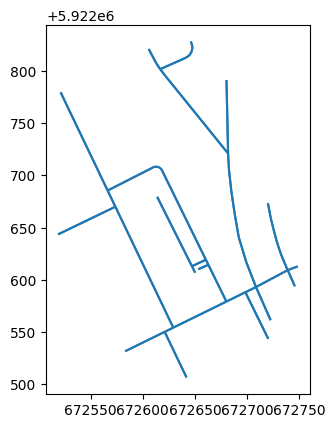

In [32]:
select_edges.plot()

In [42]:
n_plate = '6'
# for n_plate in range(8):
plate = gpd.read_file(f'/app/assets/plates/{n_plate}').to_crs(default_crs)
select_actual_nodes, select_actual_edges = get_nodes_and_edges_in_plate(actual_nodes, actual_edges, plate)
select_future_nodes, select_future_edges = get_nodes_and_edges_in_plate(future_nodes, future_edges, plate)

# mask_future_edges = ~select_future_edges['osmid'].isin(select_actual_edges['osmid'])
# future_edges_to_change = gpd.sjoin(select_future_edges[mask_future_edges], plate, how='inner')

# mask_actual_edges = ~select_actual_edges['osmid'].isin(select_future_edges['osmid'])
# actual_edges_to_change = gpd.sjoin(select_actual_edges[mask_actual_edges], plate, how='inner')
# print(f'{n_plate} : {edges_to_change.shape}')

<Axes: >

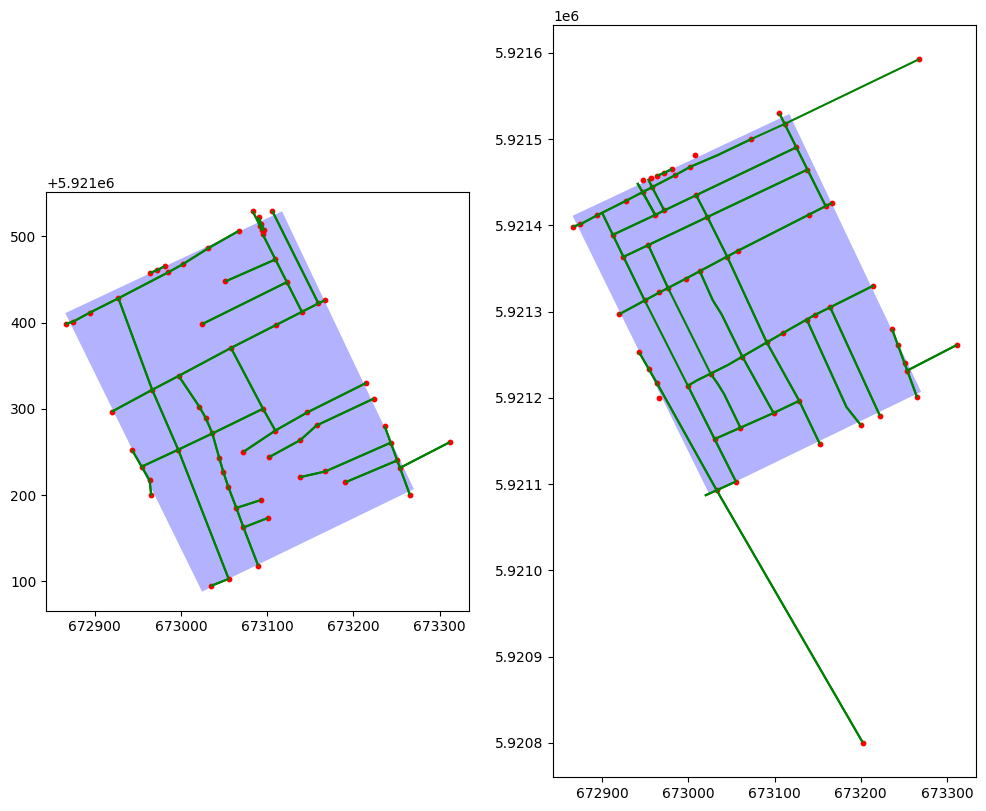

In [46]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12,18))
plate.plot(ax=ax[0], color='blue', alpha=0.3)
select_actual_nodes.plot(ax=ax[0], color='red', markersize=10)
select_actual_edges.plot(ax=ax[0], color='green', markersize=0.5)

plate.plot(ax=ax[1], color='blue', alpha=0.3)
select_future_nodes.plot(ax=ax[1], color='red', markersize=10)
select_future_edges.plot(ax=ax[1], color='green', markersize=0.5)

# plate.plot(ax=ax[2], color='blue', alpha=0.3)
# select_actual_edges.plot(ax=ax[2], color='green', markersize=0.5)
# actual_edges_to_change.plot(ax=ax[2], color='red', markersize=20)

# plate.plot(ax=ax[3], color='blue', alpha=0.3)
# select_future_edges.plot(ax=ax[3], color='green', markersize=0.5)
# future_edges_to_change.plot(ax=ax[3], color='red', markersize=20)

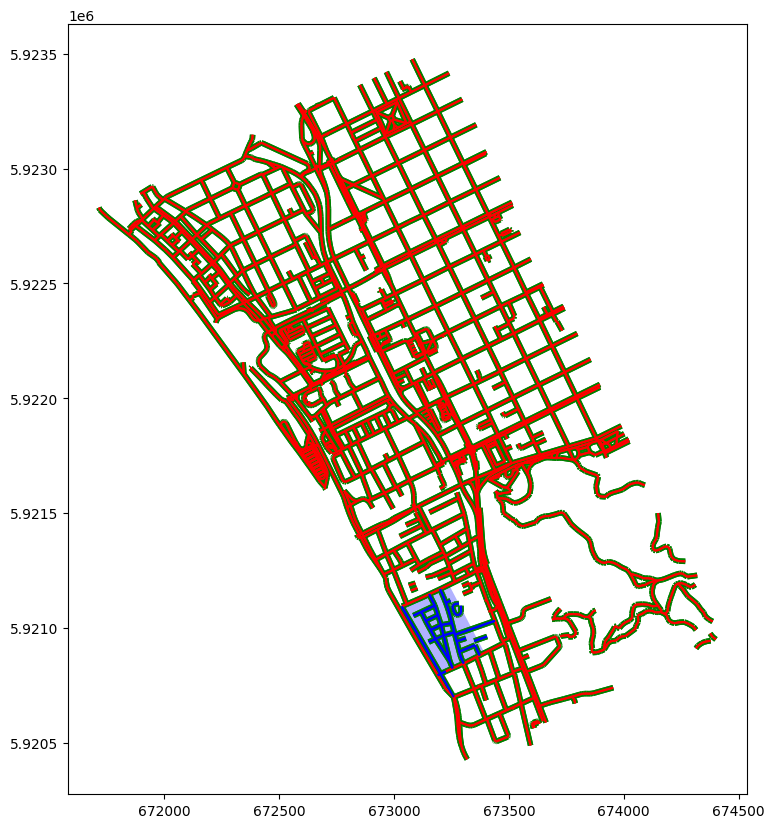

In [29]:
n_plate = '7'
# for n_plate in range(8):
plate = gpd.read_file(f'/app/assets/plates/{n_plate}').to_crs(default_crs)
select_actual_nodes, select_actual_edges = get_nodes_and_edges_in_plate(actual_nodes, actual_edges, plate)
select_future_nodes, select_future_edges = get_nodes_and_edges_in_plate(future_nodes, future_edges, plate)
mask_future_edges = ~select_future_edges['osmid'].isin(select_actual_edges['osmid'])
new_edges = gpd.sjoin(select_future_edges[mask_future_edges], plate, how='inner')

deleted_actual_edges = actual_edges[~actual_edges['osmid'].isin(select_actual_edges['osmid'])]
deleted_actual_nodes = actual_nodes[~actual_nodes['osmid'].isin(select_actual_nodes['osmid'])]

edges_updated = pd.concat([deleted_actual_edges, select_future_edges])
nodes_updated = pd.concat([deleted_actual_nodes, select_future_nodes])

deleted_actual_edges = gpd.sjoin(deleted_actual_edges, area_scope, how='inner')
select_future_edges = gpd.sjoin(select_future_edges, area_scope, how='inner')
edges_updated = gpd.sjoin(edges_updated, area_scope, how='inner')

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
plate.plot(ax=ax, color='blue', alpha=0.3)
edges_updated.plot(ax=ax, color='green', linewidth=4)
deleted_actual_edges.plot(ax=ax, color='red', markersize=10)
select_future_edges.plot(ax=ax, color='blue', markersize=10)
def extract_sub_network(nodes, edges, plate):
    return None

In [3]:
import os
from glob import glob

plates_path = '/app/assets/plates'
plates_files = glob(os.path.join(plates_path, '*'))

In [9]:
file = plates_files[0]
file
os.path.split(file)[-1]

'1'